In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, WeekdayLocator
from datetime import datetime, timedelta

In [49]:
def fxsim(num_sim, num_days, spot, vol, usd_rate, eur_rate):
    time_step = 1 / 365
    rate_diff = usd_rate - eur_rate
    
    results = np.zeros((num_sim, num_days + 1))
    
    results[:, 0] = spot
    
    for day in range(1, num_days + 1):
        drift_component = (rate_diff - 0.5 * vol ** 2) * time_step
        
        random_component = vol * np.sqrt(time_step) * np.random.normal(0, 1, num_sim)
        
        results[:, day] = results[:, day - 1] * np.exp(drift_component + random_component)
        
    return results

In [50]:
# parameters
spot = 1.1000
vol = 6 / 100
usd_rate = 5.5 / 100
eur_rate = 4.25 / 100
num_sim = 10000
num_days = 126

results = fxsim(num_sim, num_days, spot, vol, usd_rate, eur_rate)

In [51]:
final = results[:, -1]

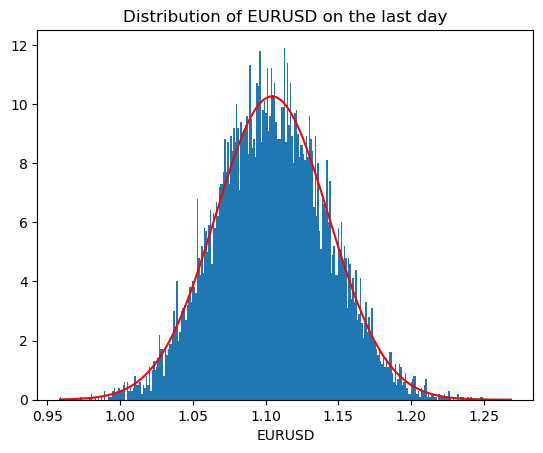

In [52]:
final_mean = np.mean(final)
final_std = np.std(final)

bins_width = 0.001

bins = np.arange(min(final), max(final), bins_width)

plt.hist(final, bins, density = True)

plt.plot(bins, (1 / (final_std * np.sqrt(2 * np.pi))) * np.exp(- (bins - final_mean) ** 2 / (2 * final_std ** 2)), color = 'r')

plt.title('Distribution of EURUSD on the last day')
plt.xlabel('EURUSD')

plt.show()

In [53]:
mean_spot = np.mean(results, axis = 0)
std_spot = np.std(results, axis = 0)

lower_bound = np.percentile(results, 5, axis = 0)
upper_bound = np.percentile(results, 95, axis = 0)

time = np.arange(num_days + 1)

In [54]:
current_date = datetime(2023, 7, 31)

weekdays = []

while len(weekdays) < num_days + 1:
        if current_date.weekday() < 5:  # Monday to Friday (0 to 4)
            weekdays.append(current_date)
        current_date += timedelta(days=1)

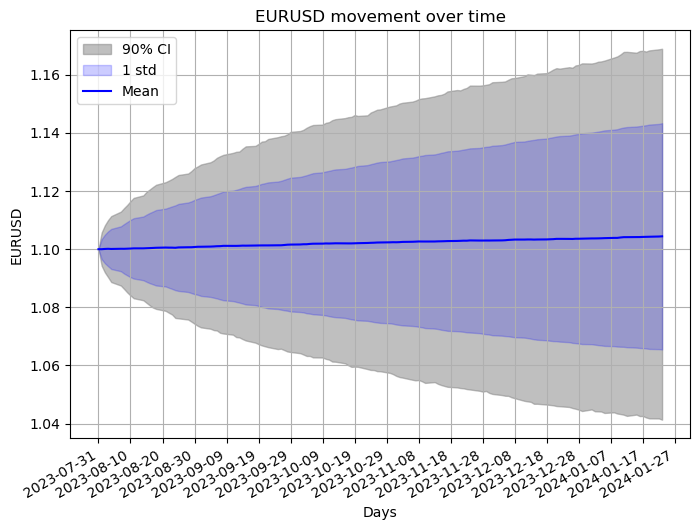

In [55]:
plt.figure(figsize = (8, 6))

plt.fill_between(weekdays, lower_bound, upper_bound, color = 'gray', alpha = 0.5, label = '90% CI')
plt.fill_between(weekdays, mean_spot + std_spot, mean_spot - std_spot, color = 'blue', alpha = 0.2, label = '1 std')
plt.plot(weekdays, mean_spot, color = 'blue', label = 'Mean')

plt.xlabel('Days')
plt.ylabel('EURUSD')
plt.title('EURUSD movement over time')
plt.legend(loc = 'upper left')

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(DayLocator(interval=10))

plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()

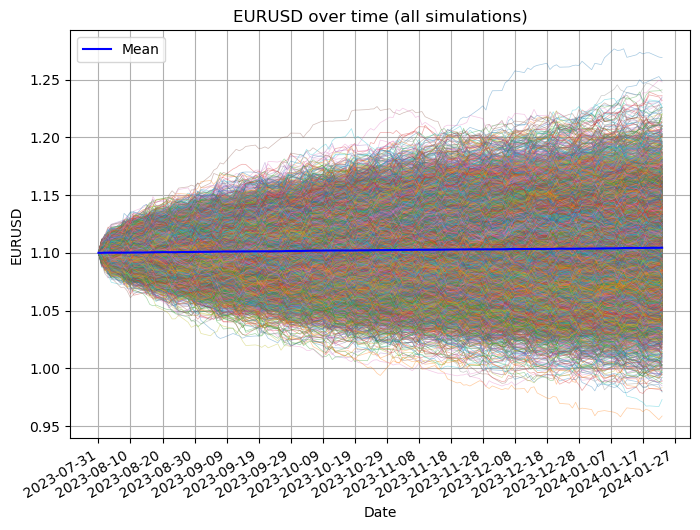

In [56]:
plt.figure(figsize = (8, 6))

for i in range(num_sim):
    plt.plot(weekdays, results[i, :], linewidth = 0.5, alpha = 0.4)

plt.plot(weekdays, mean_spot, color = 'blue', label = 'Mean')

plt.xlabel('Date')
plt.ylabel('EURUSD')
plt.title('EURUSD over time (all simulations)')
plt.legend(loc = 'upper left')

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(DayLocator(interval=10))

plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()

In [57]:
def fxsim2(num_sim, num_days, correlation):
    time_step = 1 / 365
    
    results_eur = np.zeros((num_sim, num_days + 1))
    results_gbp = np.zeros((num_sim, num_days + 1))
    
    # parameters
    results_eur[:, 0] = 1.10
    results_gbp[:, 0] = 1.28
    
    usd_rate = 5.5 / 100
    eur_rate = 4.25 / 100
    gbp_rate = 5 / 100
    vol_eur = 6 / 100
    vol_gbp = 8 / 100
    
    drift_eur = (usd_rate - eur_rate - 0.5 * vol_eur ** 2) * time_step
    drift_gbp = (usd_rate - gbp_rate - 0.5 * vol_gbp ** 2) * time_step
    
    # Create the correlation matrix for Cholesky decomposition
    corr_matrix = np.array([[1, correlation], [correlation, 1]])

    # Perform Cholesky decomposition
    chol_matrix = np.linalg.cholesky(corr_matrix)
    
    for day in range(1, num_days + 1):
        # Generate independent random variables for EURUSD and GBPUSD
        random_eur = np.random.normal(0, 1, num_sim)
        random_gbp = np.random.normal(0, 1, num_sim)
        
        # Calculate the correlated random variables using Cholesky decomposition
        random_corr = np.dot(chol_matrix, np.array([random_eur, random_gbp]))
        
        # Generate random components for EURUSD and GBPUSD
        random_components_eur = vol_eur * np.sqrt(time_step) * random_corr[0]
        random_components_gbp = vol_gbp * np.sqrt(time_step) * random_corr[1]
        
        # Update spot prices for EURUSD and GBPUSD
        results_eur[:, day] = results_eur[:, day - 1] * np.exp(drift_eur + random_components_eur)
        results_gbp[:, day] = results_gbp[:, day - 1] * np.exp(drift_gbp + random_components_gbp)
        
    return results_eur, results_gbp

# parameters
correlation = 0.8
num_sim = 10000
num_days = 126

results_eur, results_gbp = fxsim2(num_sim, num_days, correlation)

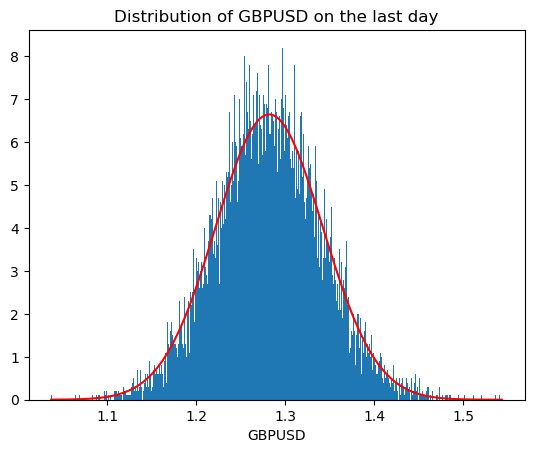

In [58]:
gbp = results_gbp[:, -1]

gbp_finalmean = np.mean(gbp)
gbp_finalstd = np.std(gbp)

gbp_bins = np.arange(min(gbp), max(gbp), bins_width)

plt.hist(gbp, gbp_bins, density = True)

plt.plot(gbp_bins, (1 / (gbp_finalstd * np.sqrt(2 * np.pi))) 
         * np.exp(- (gbp_bins - gbp_finalmean) ** 2 / (2 * gbp_finalstd ** 2)), color = 'r')

plt.title('Distribution of GBPUSD on the last day')
plt.xlabel('GBPUSD')

plt.show()

In [59]:
gbp_mean = np.mean(results_gbp, axis = 0)
gbp_std = np.std(results_gbp, axis = 0)

gbp_lower_bound = np.percentile(results_gbp, 5, axis = 0)
gbp_upper_bound = np.percentile(results_gbp, 95, axis = 0)

eur_mean = np.mean(results_eur, axis = 0)
eur_std = np.std(results_eur, axis = 0)

eur_lower_bound = np.percentile(results_eur, 5, axis = 0)
eur_upper_bound = np.percentile(results_eur, 95, axis = 0)

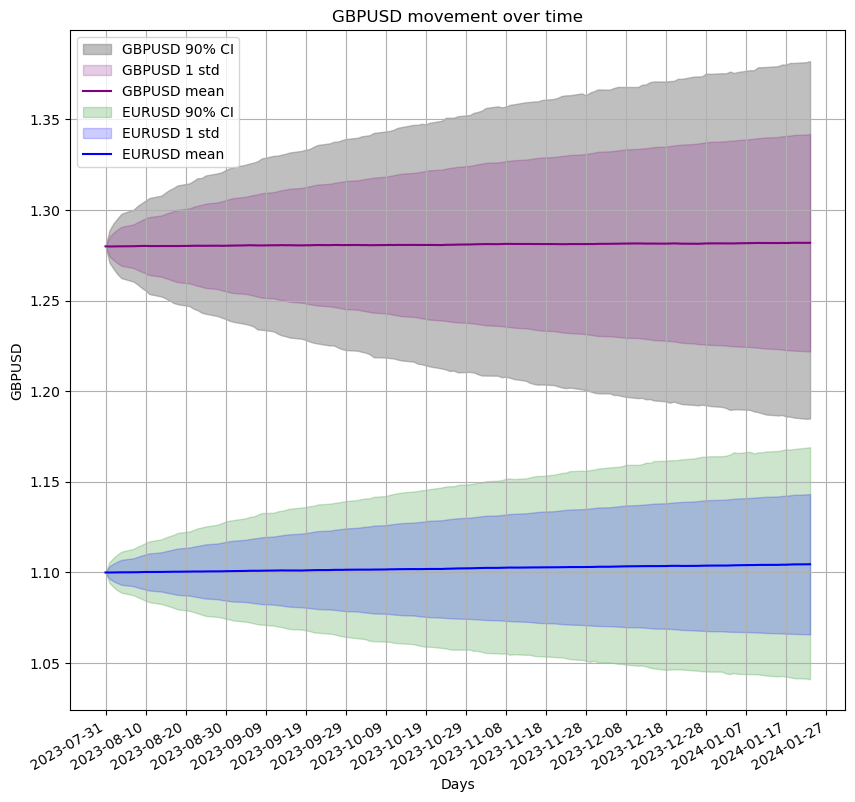

In [60]:
plt.figure(figsize = (10, 10))

plt.fill_between(weekdays, gbp_lower_bound, gbp_upper_bound, color = 'gray', alpha = 0.5, label = 'GBPUSD 90% CI')
plt.fill_between(weekdays, gbp_mean + gbp_std, gbp_mean - gbp_std, color = 'purple', alpha = 0.2, label = 'GBPUSD 1 std')
plt.plot(weekdays, gbp_mean, color = 'purple', label = 'GBPUSD mean')

plt.fill_between(weekdays, eur_lower_bound, eur_upper_bound, color = 'green', alpha = 0.2, label = 'EURUSD 90% CI')
plt.fill_between(weekdays, eur_mean + eur_std, eur_mean - eur_std, color = 'blue', alpha = 0.2, label = 'EURUSD 1 std')
plt.plot(weekdays, eur_mean, color = 'blue', label = 'EURUSD mean')

plt.xlabel('Days')
plt.ylabel('GBPUSD')
plt.title('GBPUSD movement over time')
plt.legend(loc = 'upper left')

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(DayLocator(interval=10))

plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()